In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import sys
import os
from glob import glob

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)

from matplotlib.ticker import FuncFormatter
from utils.cmod5n import cmod5n_forward, cmod5n_inverse
from utils.functions import *
from scipy.stats import norm
from pyproj import Geod


In [7]:
df_bsens1 = pd.read_parquet('../results/wv1_b-sensitivity_results.parquet')
df_bsens2 = pd.read_parquet('../results/wv2_b-sensitivity_results.parquet')

In [8]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")

df1r = pd.read_parquet("../results/wv1_results_updated.parquet")
df2r = pd.read_parquet("../results/wv2_results_updated.parquet")

df1w = pd.read_parquet("../results/wv1_wind_results.parquet")
df2w = pd.read_parquet("../results/wv2_wind_results.parquet")

df1r["renamed_filename"] = df1r.sar_filepath.apply(lambda x: x.split("/")[-1])
df2r["renamed_filename"] = df2r.sar_filepath.apply(lambda x: x.split("/")[-1])

df1w["renamed_filename"] = df1w.sar_filepath.apply(lambda x: x.split("/")[-1])
df2w["renamed_filename"] = df2w.sar_filepath.apply(lambda x: x.split("/")[-1])

idxmax = df1w.k_values_wind.apply(lambda x: len(x)).argmax()
max_len = df1w.k_values_wind.apply(lambda x: len(x)).max()

df1r = pad_arrays_to_max_length(df1r, 'radial_psd', max_len)
df2r = pad_arrays_to_max_length(df2r, 'radial_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_residual_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_residual_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_field_residual_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_field_residual_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_residual_psd_improved', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_residual_psd_improved', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_sigma_sar_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_sigma_sar_psd', max_len)

df1 = pd.merge(left=df1, right=df1r, on='renamed_filename')
df1 = pd.merge(left=df1, right=df1w, on='renamed_filename')

df2 = pd.merge(left=df2, right=df2r, on='renamed_filename')
df2 = pd.merge(left=df2, right=df2w, on='renamed_filename')

df1 = df1.rename(columns={"sar_filepath_y":"sar_filepath"})
df2 = df2.rename(columns={"sar_filepath_y":"sar_filepath"})

df1 = pd.merge(left=df1, right=df_bsens1, on='sar_filepath')
df2 = pd.merge(left=df2, right=df_bsens2, on='sar_filepath')

In [9]:
# df1['residual_nrcs_rmse'] = np.sqrt( (df1['sigma_cmod_median'] - df1['sigma_sar_median'])**2)
# df2['residual_nrcs_rmse'] = np.sqrt( (df2['sigma_cmod_median'] - df2['sigma_sar_median'])**2)

v = 20

df1 = create_phi_bins_columns(df1, 'phi_nominal_median', v)
df2 = create_phi_bins_columns(df2, 'phi_nominal_median', v)

df1 = df1.dropna(subset=['residual_median'])
df2 = df2.dropna(subset=['residual_median'])

df1 = df1[df1.class_1 != "SI"]
df2 = df2[df2.class_1 != "SI"]

df1 = df1[df1.class_2 != "SI"]
df2 = df2[df2.class_2 != "SI"]

df1 = df1[df1.class_3 != "SI"]
df2 = df2[df2.class_3 != "SI"]

In [10]:
# mad1 = np.median(np.abs(df1.residual_median - np.median(df1.residual_median)))
ts1 = np.median(df1.residual_median) # + 2 * mad1

# mad2 = np.median(np.abs(df2.residual_median - np.median(df2.residual_median)))
ts2 = np.median(df2.residual_median) # + 2 * mad2

df1['nrcs_retrieval'] = df1['residual_median'].apply(lambda x: bad_or_good_retrieval(x, ts1))
df2['nrcs_retrieval'] = df2['residual_median'].apply(lambda x: bad_or_good_retrieval(x, ts2))


In [132]:
def radial_profile(data, center=None):
    y, x = np.indices(data.shape)
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])
    
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)
    
    tbin = np.bincount(r.ravel(), weights=data.ravel())
    nr = np.bincount(r.ravel())
    nr[nr == 0] = 1  
    
    return np.arange(len(tbin)), tbin / nr

def process_wind_field(wind_field):
    fft_wind = np.fft.fft2(wind_field)
    fft_shifted = np.fft.fftshift(fft_wind)
    psd = np.abs(fft_shifted)**2
    distances, radial_psd = radial_profile(psd)
    return radial_psd, distances, psd

def add_subkm_noise(sigma_sar, pixel_size, noise_levels, seed=None):
    """
    Add noise to sigma_sar at spatial scales < 1 km using spatial-domain filtering.
    
    Parameters:
        sigma_sar: 2D array of original sigma0 values
        pixel_size: pixel size in meters
        noise_levels: list of standard deviations for noise
        seed: optional random seed
        
    Returns:
        List of sigma_sar arrays with added noise (one per noise level)
    """
    rng = np.random.default_rng(seed)
    subkm_noise_maps = []

    # Gaussian kernel stddev for ~1km scale and a broader one
    
    s = 100


    for noise_std in noise_levels:
        white_noise = rng.normal(0, noise_std, sigma_sar.shape)


        highpass = white_noise - gaussian_filter(white_noise, sigma = s / pixel_size)
        subkm_noise = gaussian_filter(highpass, sigma = s / pixel_size)

        sigma_noisy = sigma_sar + subkm_noise

        subkm_noise_maps.append(sigma_noisy)

        subkm_noise -= subkm_noise.mean()
        sigma_noisy = np.clip(sigma_sar + subkm_noise, a_min=0, a_max=None)

    return subkm_noise_maps


def normalized_array(array):
    normalized = (array - array.min()) / (array.max() - array.min())
    return normalized

In [133]:
list_of_nc_files_2020 = glob("../processed_data/Sentinel1/WV/2020/*.nc")
fn = list_of_nc_files_2020[2]
ds = xr.open_dataset(fn)

fn_nc = fn.split("\\")[-1]

if len(df2[df2.renamed_filename == fn_nc]) > 0:
    era5_wdir = df2[df2.renamed_filename == fn_nc].wdir.values[0]
else:
    era5_wdir = df1[df1.renamed_filename == fn_nc].wdir.values[0]


In [134]:
sigma0 = ds.sigma0.values[0]
sigma0 = sigma0[:-1, :]
ground_heading = ds.ground_heading.values
incidence = ds.incidence.values

azimuth_look = np.mod(ground_heading + 90, 360)
phi = compute_phi(era5_wdir, azimuth_look)

In [135]:
PSD_sigma0_radial, distances, PSD_sigma0_2d = process_wind_field(sigma0)

pixel_size = 100
k_values = distances * (1.0 / (pixel_size * max(PSD_sigma0_2d.shape)))

Signature: bootstrap_median_ci(data, n_bootstrap=1000, confidence=0.95)
Docstring:
Calculate bootstrap confidence intervals for median

Parameters:
data: 2D array (samples x wavelengths)
n_bootstrap: number of bootstrap samples
confidence: confidence level (0.95 for 95%)

Returns:
median, lower_ci, upper_ci (all arrays of length = n_wavelengths)
File:      c:\users\trouv\code\msc-thesis\utils\functions.py
Type:      function

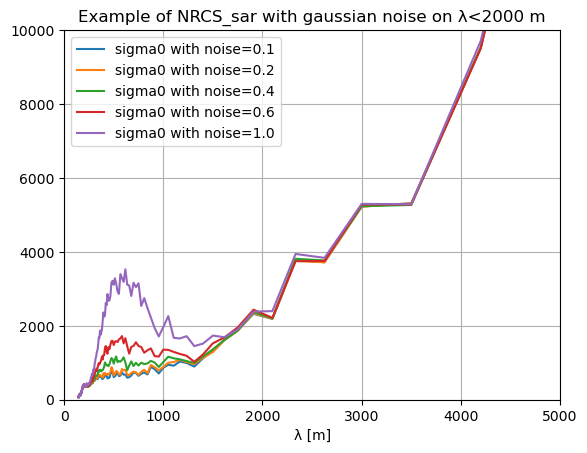

In [139]:
noise_levels = [0.05, 0.1, 0.2, 0.3, 0.5]
noise_levels = [n*2 for n in noise_levels]
subkm_noise = add_subkm_noise(sigma0, pixel_size, noise_levels, seed=None)

for i, sigma0_noise in enumerate(subkm_noise):
    # sigma0_noise = sigma0 + np.random.normal(0, noise_levels[i], sigma0.shape)
    PSD_sigma0_radial_noise, _, _ = process_wind_field(sigma0_noise)
    
    plt.plot(1/k_values, PSD_sigma0_radial_noise, label=f"sigma0 with noise={noise_levels[i]}")
plt.ylim(0, 10000)
plt.xlim(0, 5000)
plt.grid()
plt.legend()
plt.title("Example of NRCS_sar with gaussian noise on λ<2000 m")
plt.xlabel("λ [m]")
plt.show()

In [16]:
df_bsens1 = pd.merge(df_bsens1, right=df1[['sar_filepath', 'phi_bins']], on='sar_filepath')
df_bsens2 = pd.merge(df_bsens2, right=df2[['sar_filepath', 'phi_bins']], on='sar_filepath')

Text(0, 0.5, 'sigma0_cmod_median')

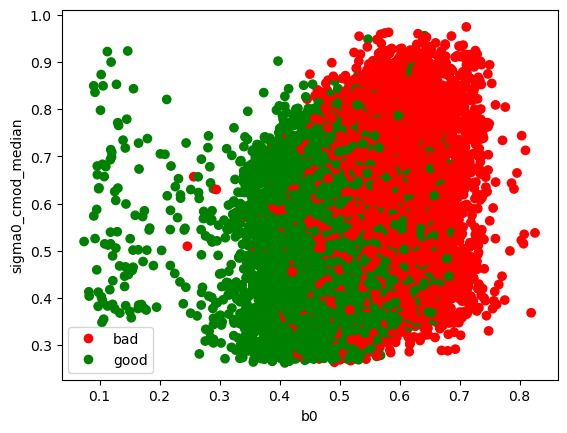

In [17]:
df1['b0_median'] = df1.b0.apply(lambda x: x['median'])

from matplotlib.colors import ListedColormap

color_map = ListedColormap(['red', 'green'])  # assuming 'bad' = red, 'good' = green
color_values = df1.nrcs_retrieval.map({'bad': 0, 'good': 1})

plt.scatter(df1['b0_median'], df1['sigma0_cmod_median'], c=color_values, cmap=color_map)


from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='bad', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='good', markerfacecolor='green', markersize=8)
]

plt.legend(handles=legend_elements)
plt.xlabel("b0")
plt.ylabel("sigma0_cmod_median")


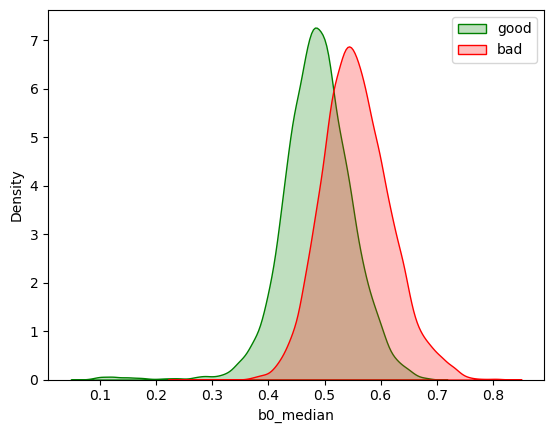

In [18]:
import seaborn as sns

plt.figure()
sns.kdeplot(df1[df1.nrcs_retrieval == 'good']['b0_median'], label='good', color='green', fill=True)
sns.kdeplot(df1[df1.nrcs_retrieval == 'bad']['b0_median'], label='bad', color='red', fill=True)
plt.xlabel("b0_median")
plt.ylabel("Density")
plt.legend()


In [19]:
b0_1med, b0_2med, b1_1med, b1_2med, b2_1med, b2_2med = [], [], [], [], [], []
b0_1bot, b0_2bot, b1_1bot, b1_2bot, b2_1bot, b2_2bot = [], [], [], [], [], []
b0_1top, b0_2top, b1_1top, b1_2top, b2_1top, b2_2top = [], [], [], [], [], []


intervals = np.arange(int(-180+v/2), int(181-v/2), int(v))
intervals = np.append(intervals, intervals[0])

n_rows = (len(intervals)-1)/3

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    df2_plot = df2[df2.phi_bins == f"[{a}, {b})"]
    df1_plot = df1[df1.phi_bins == f"[{a}, {b})"]   

    b0_df1_med, b0_df1_bot, b0_df1_top = bootstrap_median_ci(df1_plot.b0.apply(lambda x: x['median']))
    b0_df2_med, b0_df2_bot, b0_df2_top = bootstrap_median_ci(df2_plot.b0.apply(lambda x: x['median']))

    b1_df1_med, b1_df1_bot, b1_df1_top = bootstrap_median_ci(df1_plot.b1.apply(lambda x: x['median']))
    b1_df2_med, b1_df2_bot, b1_df2_top = bootstrap_median_ci(df2_plot.b1.apply(lambda x: x['median']))

    b2_df1_med, b2_df1_bot, b2_df1_top = bootstrap_median_ci(df1_plot.b2.apply(lambda x: x['median']))
    b2_df2_med, b2_df2_bot, b2_df2_top = bootstrap_median_ci(df2_plot.b2.apply(lambda x: x['median']))

    b0_1med.append(b0_df1_med)
    b0_1bot.append(b0_df1_bot)
    b0_1top.append(b0_df1_top)

    b0_2med.append(b0_df2_med)
    b0_2bot.append(b0_df2_bot)
    b0_2top.append(b0_df2_top)

    b1_1med.append(b1_df1_med)
    b1_1bot.append(b1_df1_bot)
    b1_1top.append(b1_df1_top)

    b1_2med.append(b1_df2_med)
    b1_2bot.append(b1_df2_bot)
    b1_2top.append(b1_df2_top)

    b2_1med.append(b2_df1_med)
    b2_1bot.append(b2_df1_bot)
    b2_1top.append(b2_df1_top)

    b2_2med.append(b2_df2_med)
    b2_2bot.append(b2_df2_bot)
    b2_2top.append(b2_df2_top)

    

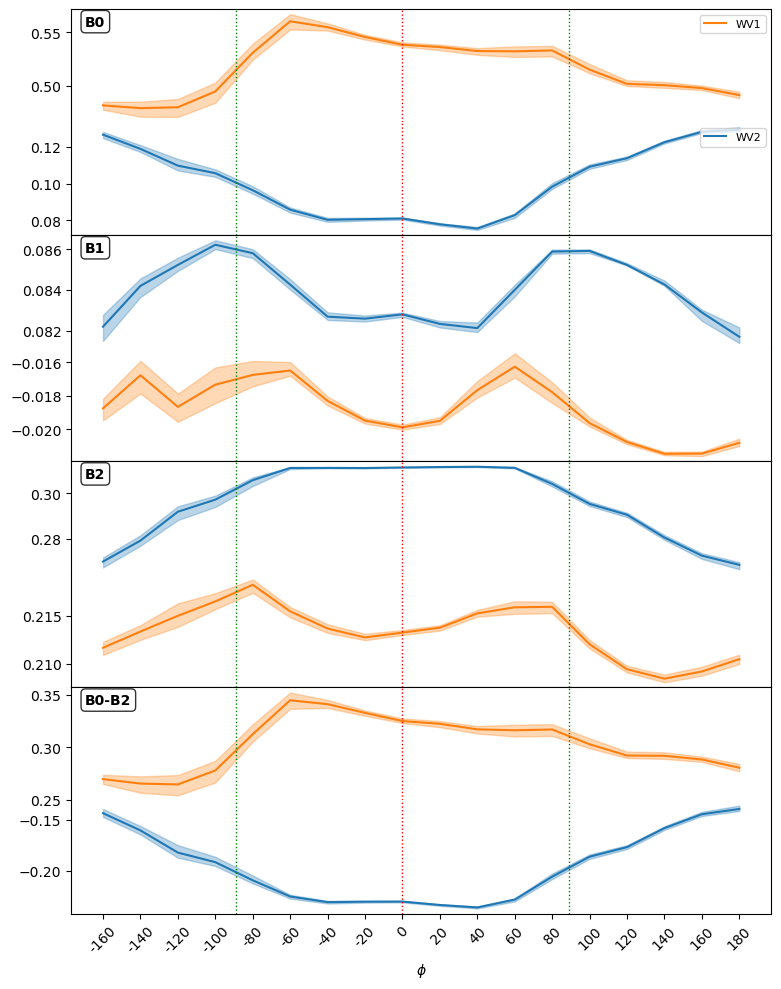

In [20]:
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 10))
gs = GridSpec(8, 1, height_ratios=[1]*8, hspace=0)
bs = ["B0", "B1", "B2", "B0‑B2"]

for i, (med1, bot1, top1, med2, bot2, top2) in enumerate(zip(
    [b0_1med, b1_1med, b2_1med, np.array(b0_1med) - np.array(b2_1med)],
    [b0_1bot, b1_1bot, b2_1bot, np.array(b0_1bot) - np.array(b2_1top)],
    [b0_1top, b1_1top, b2_1top, np.array(b0_1top) - np.array(b2_1bot)],
    [b0_2med, b1_2med, b2_2med, np.array(b0_2med) - np.array(b2_2med)],
    [b0_2bot, b1_2bot, b2_2bot, np.array(b0_2bot) - np.array(b2_2top)],
    [b0_2top, b1_2top, b2_2top, np.array(b0_2top) - np.array(b2_2bot)],
)):
    
    # Calculate midpoint of each dataset to determine vertical order
    mid1 = (max(top1) + min(bot1)) / 2
    mid2 = (max(top2) + min(bot2)) / 2
    
    ax_top = fig.add_subplot(gs[i*2, 0])
    ax_bot = fig.add_subplot(gs[i*2+1, 0], sharex=ax_top)
    
    # Place dataset with higher y-values on top
    if mid1 > mid2:
        # wv1 has higher values - put on top
        ax_top.plot(med1, color="tab:orange", label="WV1")
        ax_top.fill_between(range(len(med1)), bot1, top1, color="tab:orange", alpha=0.3)
        
        ax_bot.plot(med2, color="tab:blue", label="WV2")
        ax_bot.fill_between(range(len(med2)), bot2, top2, color="tab:blue", alpha=0.3)
        
        # Add padding to y-limits
        y1_range = max(top1) - min(bot1)
        y2_range = max(top2) - min(bot2)
        ax_top.set_ylim(min(bot1) - 0.05*y1_range, max(top1) + 0.05*y1_range)
        ax_bot.set_ylim(min(bot2) - 0.05*y2_range, max(top2) + 0.05*y2_range)
    else:
        # wv2 has higher values - put on top
        ax_top.plot(med2, color="tab:blue", label="WV2")
        ax_top.fill_between(range(len(med2)), bot2, top2, color="tab:blue", alpha=0.3)
        
        ax_bot.plot(med1, color="tab:orange", label="WV1")
        ax_bot.fill_between(range(len(med1)), bot1, top1, color="tab:orange", alpha=0.3)
        
        # Add padding to y-limits
        y1_range = max(top1) - min(bot1)
        y2_range = max(top2) - min(bot2)
        ax_top.set_ylim(min(bot2) - 0.05*y2_range, max(top2) + 0.05*y2_range)
        ax_bot.set_ylim(min(bot1) - 0.05*y1_range, max(top1) + 0.05*y1_range)
    
    # Set x-axis ticks for all subplots
    ax_top.set_xticks(np.arange(0, 18, 1))
    ax_bot.set_xticks(np.arange(0, 18, 1))
    
    # Add title as text box in top left of top subplot
    ax_top.text(0.02, 0.95, bs[i], transform=ax_top.transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", alpha=0.8),
                fontsize=10, verticalalignment='top', fontweight='bold')
    
    # Hide connecting spines but keep tick marks
    ax_top.spines['bottom'].set_visible(False)
    ax_bot.spines['top'].set_visible(False)
    
    # Show tick marks on all subplots but hide labels except on last
    if i < 3:
        ax_top.tick_params(which='both', bottom=True, labelbottom=False)
        ax_bot.tick_params(which='both', bottom=True, labelbottom=False)
    else:  # Last iteration (B0-B2)
        ax_top.tick_params(which='both', bottom=True, labelbottom=False)
        ax_bot.set_xlabel("$\\phi$")
        ax_bot.set_xticklabels([str(int(-160 + i*v)) for i in range(18)], rotation=45)
        ax_bot.tick_params(which='both', bottom=True, labelbottom=True)
    
    # Add legend to the first subplot
    if i == 0:
        ax_top.legend(loc='upper right', fontsize=8)
        ax_bot.legend(loc='upper right', fontsize=8)

# Add vertical lines to all axes
for ax in fig.axes:
    for xpos in [17//2, 17/4.8, 17/1.36666]:
        ax.axvline(xpos, color="red" if xpos==17//2 else "green", linestyle="dotted", linewidth=1)

plt.tight_layout()
plt.show()

In [21]:
def cmod_fn(B0, B1, B2, intervals):
    phi = np.array(intervals[:-1])
    fi = np.radians(phi)
    csfi = np.cos(fi)
    cs2_fi = 2*csfi*csfi - 1.00
    z_pow = 1.6

    return B0 * (1.0 + B1 * csfi + B2 * cs2_fi) ** z_pow

def get_phi_bin_mid_point(s):
    n1 = int(s.split(",")[0][1:])
    n2 = int(s.split(",")[-1][:-1])
    return (n2+n1)/2 if (n2+n1)!=0 else 180

In [22]:
# If your bins are regular 20-degree intervals from -180 to 180
result_df1 = df1.groupby('phi_bins')['mean_sigma0'].mean().reset_index()

# Create a mapping of expected order
bin_order = [f"[{i}, {i+20})" for i in range(-170, 170, 20)] + ["[170, -170)"]

# Convert to categorical with specified order
result_df1['phi_bins'] = pd.Categorical(result_df1['phi_bins'], categories=bin_order, ordered=True)
result_df1 = result_df1.sort_values('phi_bins').reset_index(drop=True)
result_df1['phi_bin_mid'] = result_df1.phi_bins.apply(lambda s: get_phi_bin_mid_point(s))

In [23]:
# If your bins are regular 20-degree intervals from -180 to 180
result_df2 = df2.groupby('phi_bins')['mean_sigma0'].mean().reset_index()

# Convert to categorical with specified order
result_df2['phi_bins'] = pd.Categorical(result_df2['phi_bins'], categories=bin_order, ordered=True)
result_df2 = result_df2.sort_values('phi_bins').reset_index(drop=True)
result_df2['phi_bin_mid'] = result_df2.phi_bins.apply(lambda s: get_phi_bin_mid_point(s))

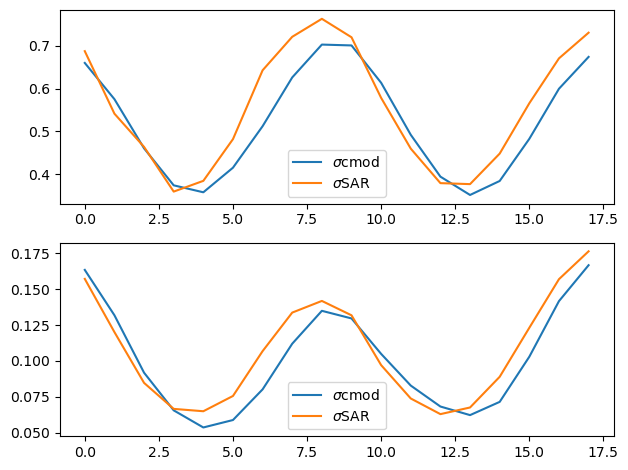

In [24]:
fig, axes = plt.subplots(2,1)
for i, ax in enumerate(axes):
    b0 = f"b0_{i+1}med"
    b1 = f"b1_{i+1}med"
    b2 = f"b2_{i+1}med"

    result_df = f"result_df{i+1}"

    ax.plot(cmod_fn(eval(b0), eval(b1), eval(b2), intervals), label="$\sigma$cmod")
    ax.plot(eval(result_df)['mean_sigma0'], label="$\sigma$SAR")
    ax.legend()
    # ax.set_xticks()
plt.tight_layout()

In [25]:
cmod_wv1 = cmod_fn(b0_1med, b1_1med, b2_1med, intervals)
cmod_wv2 = cmod_fn(b0_2med, b1_2med, b2_2med, intervals)

In [26]:
sigma0 = ds.sigma0[:, :-1][0]

In [27]:

geod = Geod(ellps='WGS84')

# Pick central area
lat1 = ds.latitude[:-1, :-1]
lon1 = ds.longitude[:-1, :-1]
lat2 = ds.latitude[1:, :-1]
lon2 = ds.longitude[1:, :-1]
lat3 = ds.latitude[:-1, 1:]
lon3 = ds.longitude[:-1, 1:]

# Line spacing (along-track)
_, _, dy = geod.inv(lon1, lat1, lon2, lat2)

# Sample spacing (across-track)
_, _, dx = geod.inv(lon1, lat1, lon3, lat3)

# Take median resolution (in meters)
dy_m = np.median(np.abs(dy))
dx_m = np.median(np.abs(dx))


In [28]:
factor_line = int(np.round(500 / dy_m))
factor_sample = int(np.round(500 / dx_m))

sigma0_500m = sigma0.coarsen(
    line=factor_line,
    sample=factor_sample,
    boundary='trim'
).mean()



In [29]:
sigma0_500m

<xarray.DataArray 'sigma0' (line: 40, sample: 42)> Size: 13kB
array([[0.48013156, 0.50931875, 0.50535106, ..., 0.37577211, 0.40590273,
        0.44110364],
       [0.51257699, 0.56441726, 0.62307673, ..., 0.45964553, 0.48063987,
        0.4888134 ],
       [0.57712075, 0.60123179, 0.54251623, ..., 0.46519975, 0.52007166,
        0.54531183],
       ...,
       [0.56341843, 0.65296158, 0.7281445 , ..., 0.3785909 , 0.43997817,
        0.40200216],
       [0.64011303, 0.61997692, 0.69266232, ..., 0.41539039, 0.43922789,
        0.45345154],
       [0.56372385, 0.64110836, 0.67068401, ..., 0.4416742 , 0.45246237,
        0.43850019]])
Coordinates:
  * line     (line) float64 320B 60.21 181.6 303.0 ... 4.674e+03 4.795e+03
  * sample   (sample) float64 336B 67.25 202.7 338.2 ... 5.487e+03 5.622e+03
    pol      <U2 8B 'VV'
Attributes:
    history:                sigma0:\n  nesz:\n    noise_lut:\n      noise_lut...
    comment_recalibration:  kersten recalibration not applied
    comment:                not clipped, some values can be <0

In [30]:
b0_1med, b0_2med, b1_1med, b1_2med, b2_1med, b2_2med = [], [], [], [], [], []
b0_1bot, b0_2bot, b1_1bot, b1_2bot, b2_1bot, b2_2bot = [], [], [], [], [], []
b0_1top, b0_2top, b1_1top, b1_2top, b2_1top, b2_2top = [], [], [], [], [], []


intervals = np.arange(int(-180+v/2), int(181-v/2), int(v))
intervals = np.append(intervals, intervals[0])

n_rows = (len(intervals)-1)/3

for noise in noise_levels:
    print(f"Noise level: {noise}")
    noise = str(noise)
    for i in range(len(intervals)-1):
        a = intervals[i]
        b = intervals[i+1]
        
        df2_plot = df2[df2.phi_bins == f"[{a}, {b})"]
        df1_plot = df1[df1.phi_bins == f"[{a}, {b})"]   

        b0_df1_med, b0_df1_bot, b0_df1_top = bootstrap_median_ci(df1_plot.b0_stats.apply(lambda x: x[noise]['median']))
        b0_df2_med, b0_df2_bot, b0_df2_top = bootstrap_median_ci(df2_plot.b0_stats.apply(lambda x: x[noise]['median']))

        b1_df1_med, b1_df1_bot, b1_df1_top = bootstrap_median_ci(df1_plot.b1_stats.apply(lambda x: x[noise]['median']))
        b1_df2_med, b1_df2_bot, b1_df2_top = bootstrap_median_ci(df2_plot.b1_stats.apply(lambda x: x[noise]['median']))

        b2_df1_med, b2_df1_bot, b2_df1_top = bootstrap_median_ci(df1_plot.b2_stats.apply(lambda x: x[noise]['median']))
        b2_df2_med, b2_df2_bot, b2_df2_top = bootstrap_median_ci(df2_plot.b2_stats.apply(lambda x: x[noise]['median']))

        b0_1med.append(b0_df1_med)
        b0_1bot.append(b0_df1_bot)
        b0_1top.append(b0_df1_top)

        b0_2med.append(b0_df2_med)
        b0_2bot.append(b0_df2_bot)
        b0_2top.append(b0_df2_top)

        b1_1med.append(b1_df1_med)
        b1_1bot.append(b1_df1_bot)
        b1_1top.append(b1_df1_top)

        b1_2med.append(b1_df2_med)
        b1_2bot.append(b1_df2_bot)
        b1_2top.append(b1_df2_top)

        b2_1med.append(b2_df1_med)
        b2_1bot.append(b2_df1_bot)
        b2_1top.append(b2_df1_top)

        b2_2med.append(b2_df2_med)
        b2_2bot.append(b2_df2_bot)
        b2_2top.append(b2_df2_top)

    b0_1med.append(0)
    b0_1bot.append(0)
    b0_1top.append(0)

    b0_2med.append(0)
    b0_2bot.append(0)
    b0_2top.append(0)

    b1_1med.append(0)
    b1_1bot.append(0)
    b1_1top.append(0)

    b1_2med.append(0)
    b1_2bot.append(0)
    b1_2top.append(0)

    b2_1med.append(0)
    b2_1bot.append(0)
    b2_1top.append(0)

    b2_2med.append(0)
    b2_2bot.append(0)
    b2_2top.append(0)

    

    

    

Noise level: 0.1
Noise level: 0.2
Noise level: 0.4
Noise level: 0.6
Noise level: 1.0


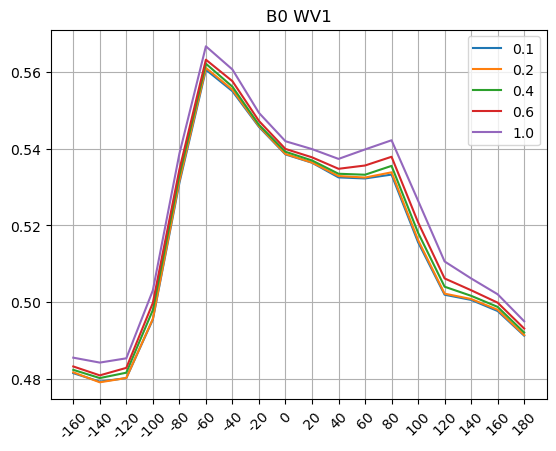

In [ ]:
def plot_b_param_with_noise(b0_1med, noise_levels, t):

    idxs = []

    for i, idx in enumerate(np.where(np.array(b0_1med) == 0)[0]):
        idxs.append(idx)
        if i == 0:
            plt.plot(b0_1med[:idx], label=f"{noise_levels[i]}")
            # plt.show()
        else:
            plt.plot(b0_1med[idxs[i-1]+1:idx], label=f"{noise_levels[i]}")

    plt.title(t)
    plt.legend()
    plt.grid()
    plt.xticks(range(18), [str(int(-160 + i*20)) for i in range(18)], rotation=45)
    plt.show()

plot_b_param_with_noise(b0_1med, noise_levels, t="B0 WV1")

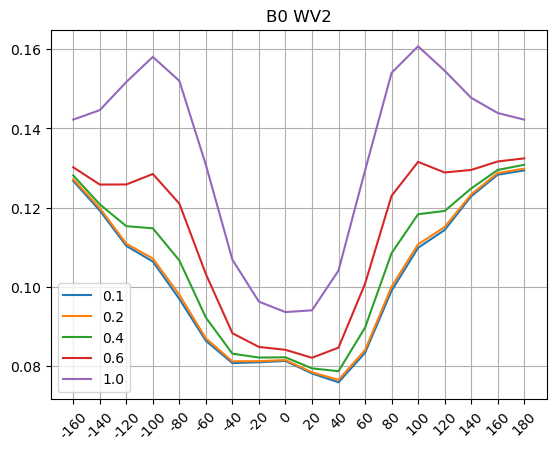

In [91]:
plot_b_param_with_noise(b0_2med, noise_levels, t="B0 WV2")

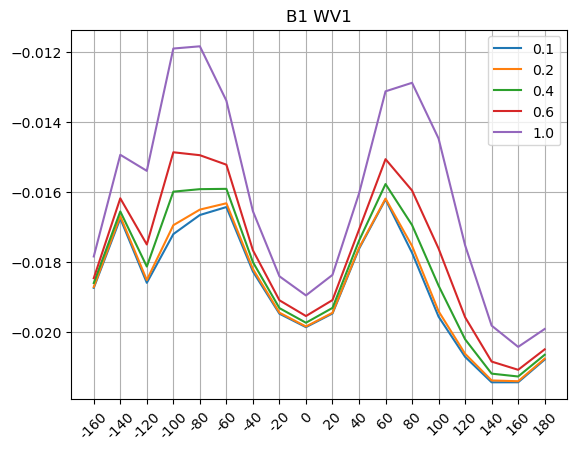

In [92]:
plot_b_param_with_noise(b1_1med, noise_levels, t="B1 WV1")

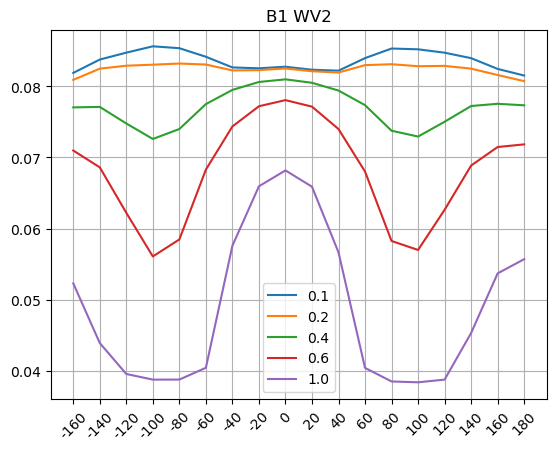

In [94]:
plot_b_param_with_noise(b1_2med, noise_levels, t="B1 WV2")

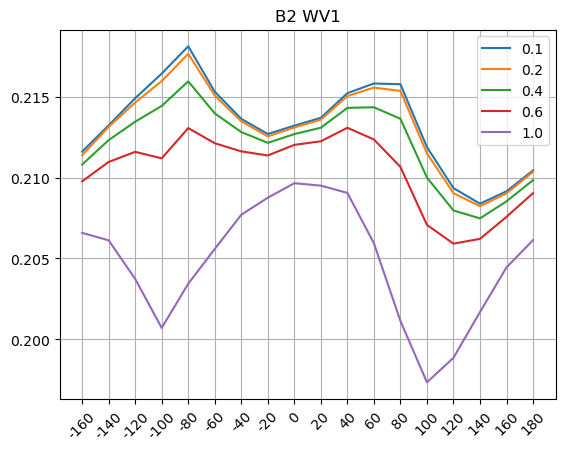

In [95]:
plot_b_param_with_noise(b2_1med, noise_levels, t="B2 WV1")

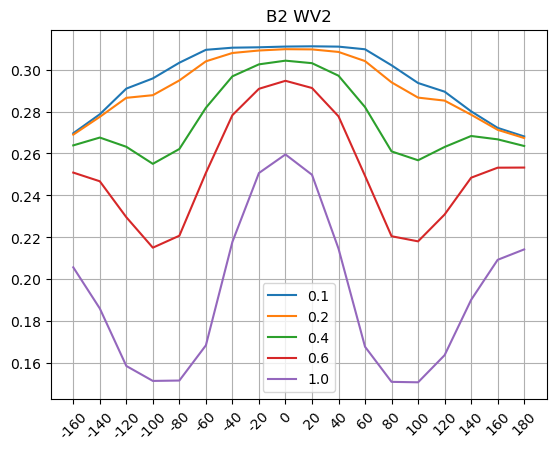

In [96]:
plot_b_param_with_noise(b2_2med, noise_levels, t="B2 WV2")

-0.9999987317275395

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_cmod_scale_sensitivity_aggregated(df, show_individual=False):
    """
    Plot CMOD scale sensitivity analysis aggregated across all phi_bins
    """
    # Extract all data from all rows
    all_data = []
    
    for idx, sensitivity_dict in enumerate(df['cmod_scale_sensitivity']):
        for noise_level, scale_data in sensitivity_dict.items():
            for scale, metrics in scale_data.items():
                all_data.append({
                    'phi_bin': idx,
                    'scale': int(scale.replace('m', '')),
                    'noise_level': noise_level.replace('noise_', '').replace('pct', '%'),
                    'rmse': metrics['rmse_degradation'],
                    'std_change': metrics['std_change_pct'],
                    'bias': metrics['bias']
                })
    
    plot_df = pd.DataFrame(all_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CMOD Scale Sensitivity Analysis (Aggregated across phi_bins)', fontsize=16)
    
    metrics = ['rmse', 'std_change', 'bias']
    titles = ['Wind Retrieval RMSE vs Scale', 'Wind Std Change vs Scale', 'Wind Bias vs Scale']
    ylabels = ['RMSE Degradation [m/s]', 'Std Change [%]', 'Bias [m/s]']
    
    for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
        ax = axes[i//2, i%2] if i < 3 else None
        if ax is None:
            continue
            
        for noise in plot_df['noise_level'].unique():
            subset = plot_df[plot_df['noise_level'] == noise]
            
            # Calculate mean and std across phi_bins for each scale
            stats = subset.groupby('scale')[metric].agg(['mean', 'std', 'count']).reset_index()
            stats['sem'] = stats['std'] / np.sqrt(stats['count'])  # Standard error
            
            # Plot individual phi_bins as light lines
            if show_individual:
                colors = plt.cm.tab10(np.linspace(0, 1, len(subset['phi_bin'].unique())))
                for j, phi_bin in enumerate(subset['phi_bin'].unique()):
                    phi_data = subset[subset['phi_bin'] == phi_bin]
                    ax.plot(phi_data['scale'], phi_data[metric], 
                           alpha=0.2, linewidth=0.5, color=colors[j])
            
            # Plot mean with error bars
            ax.errorbar(stats['scale'], stats['mean'], yerr=stats['sem'],
                       marker='o', linewidth=2, capsize=3, label=f'{noise} noise')
        
        ax.set_xlabel('Spatial Scale [m]')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')
    
    # Heatmap of mean RMSE
    rmse_data = plot_df[plot_df.columns[plot_df.columns != 'phi_bin']]
    pivot_rmse = rmse_data.groupby(['noise_level', 'scale'])['rmse'].mean().unstack()
    sns.heatmap(pivot_rmse, annot=True, fmt='.2f', cmap='Reds', ax=axes[1,1])
    axes[1,1].set_title('Mean RMSE Heatmap')
    axes[1,1].set_xlabel('Spatial Scale [m]')
    
    plt.tight_layout()
    return fig, plot_df

def plot_cmod_era5_comparison_aggregated(df, show_individual=False):
    """
    Plot CMOD vs ERA5 comparison aggregated across all phi_bins
    """
    # Extract all data from all rows
    all_data = []
    
    for idx, comparison_dict in enumerate(df['cmod_era5_scale_comparison']):
        for scale, metrics in comparison_dict.items():
            all_data.append({
                'phi_bin': idx,
                'scale': int(scale.replace('m', '')),
                'bias': metrics['bias'],
                'rmse': metrics['rmse'],
                'correlation': metrics['correlation'],
                'std_ratio': metrics['std_ratio']
            })
    
    plot_df = pd.DataFrame(all_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CMOD vs ERA5 Scale Comparison (Aggregated across phi_bins)', fontsize=16)
    
    metrics = ['bias', 'rmse', 'correlation', 'std_ratio']
    titles = ['CMOD-ERA5 Bias vs Scale', 'CMOD-ERA5 RMSE vs Scale', 
             'CMOD-ERA5 Correlation vs Scale', 'Standard Deviation Ratio vs Scale']
    ylabels = ['Bias [m/s]', 'RMSE [m/s]', 'Correlation', 'Std Ratio (CMOD/ERA5)']
    colors = ['blue', 'red', 'green', 'purple']
    markers = ['o', 's', '^', 'd']
    
    for i, (metric, title, ylabel, color, marker) in enumerate(zip(metrics, titles, ylabels, colors, markers)):
        ax = axes[i//2, i%2]
        
        # Calculate mean and std across phi_bins for each scale
        stats = plot_df.groupby('scale')[metric].agg(['mean', 'std', 'count']).reset_index()
        stats['sem'] = stats['std'] / np.sqrt(stats['count'])
        
        # Plot individual phi_bins as light lines
        if show_individual:
            for phi_bin in plot_df['phi_bin'].unique():
                phi_data = plot_df[plot_df['phi_bin'] == phi_bin]
                ax.plot(phi_data['scale'], phi_data[metric], 
                       alpha=0.2, linewidth=0.5, color=color)
        
        # Plot mean with error bars
        ax.errorbar(stats['scale'], stats['mean'], yerr=stats['sem'],
                   marker=marker, linewidth=2, color=color, capsize=3)
        
        ax.set_xlabel('Spatial Scale [m]')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log')
        
        # Add reference lines
        if metric == 'bias':
            ax.axhline(0, color='red', linestyle='--', alpha=0.5)
        elif metric == 'correlation':
            ax.set_ylim(0, 1)
        elif metric == 'std_ratio':
            ax.axhline(1, color='red', linestyle='--', alpha=0.5, label='Perfect match')
            ax.legend()
    
    plt.tight_layout()
    return fig, plot_df

def plot_combined_cmod_analysis_aggregated(df, show_individual=False):
    """
    Combined visualization of both analyses aggregated across phi_bins
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Sensitivity analysis summary
    sens_data = []
    for idx, sensitivity_dict in enumerate(df['cmod_scale_sensitivity']):
        for scale in sensitivity_dict['noise_2pct'].keys():
            scale_num = int(scale.replace('m', ''))
            sens_data.append({
                'phi_bin': idx,
                'scale': scale_num,
                'rmse_2pct': sensitivity_dict['noise_2pct'][scale]['rmse_degradation'],
                'rmse_5pct': sensitivity_dict['noise_5pct'][scale]['rmse_degradation'],
                'rmse_10pct': sensitivity_dict['noise_10pct'][scale]['rmse_degradation']
            })
    
    sens_df = pd.DataFrame(sens_data)
    
    # Plot sensitivity with aggregation
    for noise, column in [('2%', 'rmse_2pct'), ('5%', 'rmse_5pct'), ('10%', 'rmse_10pct')]:
        stats = sens_df.groupby('scale')[column].agg(['mean', 'std', 'count']).reset_index()
        stats['sem'] = stats['std'] / np.sqrt(stats['count'])
        
        if show_individual:
            colors = plt.cm.tab10(np.linspace(0, 1, len(sens_df['phi_bin'].unique())))
            for j, phi_bin in enumerate(sens_df['phi_bin'].unique()):
                phi_data = sens_df[sens_df['phi_bin'] == phi_bin]
                axes[0].plot(phi_data['scale'], phi_data[column], 
                           alpha=0.2, linewidth=0.5, color=colors[j])
        
        axes[0].errorbar(stats['scale'], stats['mean'], yerr=stats['sem'],
                        marker='o', linewidth=2, capsize=3, label=f'{noise} noise')
    
    axes[0].set_xlabel('Spatial Scale [m]')
    axes[0].set_ylabel('RMSE Degradation [m/s]')
    axes[0].set_title('CMOD Noise Sensitivity (Mean ± SEM)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xscale('log')
    
    # ERA5 comparison summary
    comp_data = []
    for idx, comparison_dict in enumerate(df['cmod_era5_scale_comparison']):
        for scale, metrics in comparison_dict.items():
            comp_data.append({
                'phi_bin': idx,
                'scale': int(scale.replace('m', '')),
                'rmse': metrics['rmse'],
                'correlation': metrics['correlation']
            })
    
    comp_df = pd.DataFrame(comp_data)
    
    ax2 = axes[1].twinx()
    
    # RMSE
    rmse_stats = comp_df.groupby('scale')['rmse'].agg(['mean', 'std', 'count']).reset_index()
    rmse_stats['sem'] = rmse_stats['std'] / np.sqrt(rmse_stats['count'])
    
    # Correlation  
    corr_stats = comp_df.groupby('scale')['correlation'].agg(['mean', 'std', 'count']).reset_index()
    corr_stats['sem'] = corr_stats['std'] / np.sqrt(corr_stats['count'])
    
    if show_individual:
        for phi_bin in comp_df['phi_bin'].unique():
            phi_data = comp_df[comp_df['phi_bin'] == phi_bin]
            axes[1].plot(phi_data['scale'], phi_data['rmse'], alpha=0.2, linewidth=0.5, color='red')
            ax2.plot(phi_data['scale'], phi_data['correlation'], alpha=0.2, linewidth=0.5, color='blue')
    
    line1 = axes[1].errorbar(rmse_stats['scale'], rmse_stats['mean'], yerr=rmse_stats['sem'],
                            marker='o', color='red', linewidth=2, capsize=3, label='RMSE')
    line2 = ax2.errorbar(corr_stats['scale'], corr_stats['mean'], yerr=corr_stats['sem'],
                        marker='s', color='blue', linewidth=2, capsize=3, label='Correlation')
    
    axes[1].set_xlabel('Spatial Scale [m]')
    axes[1].set_ylabel('RMSE [m/s]', color='red')
    ax2.set_ylabel('Correlation', color='blue')
    axes[1].set_title('CMOD vs ERA5 Performance (Mean ± SEM)')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xscale('log')
    ax2.set_ylim(0, 1)
    
    # Combine legends
    axes[1].legend([line1, line2], ['RMSE', 'Correlation'], loc='center right')
    
    plt.tight_layout()
    return fig

def plot_phi_bin_variability(df):
    """
    Show how much variability exists between different phi_bins
    """
    # ERA5 comparison variability
    comp_data = []
    for idx, comparison_dict in enumerate(df['cmod_era5_scale_comparison']):
        for scale, metrics in comparison_dict.items():
            comp_data.append({
                'phi_bin': idx,
                'scale': int(scale.replace('m', '')),
                'rmse': metrics['rmse'],
                'correlation': metrics['correlation'],
                'bias': metrics['bias']
            })
    
    comp_df = pd.DataFrame(comp_data)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    metrics = ['rmse', 'correlation', 'bias']
    titles = ['RMSE Variability', 'Correlation Variability', 'Bias Variability']
    ylabels = ['RMSE [m/s]', 'Correlation', 'Bias [m/s]']
    
    for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
        # Box plot showing spread across phi_bins for each scale
        scales = sorted(comp_df['scale'].unique())
        data_for_box = [comp_df[comp_df['scale'] == scale][metric].values for scale in scales]
        
        axes[i].boxplot(data_for_box, labels=[f'{s}m' for s in scales])
        axes[i].set_xlabel('Spatial Scale')
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(title)
        axes[i].grid(True, alpha=0.3)
        
        if metric == 'bias':
            axes[i].axhline(0, color='red', linestyle='--', alpha=0.5)
        elif metric == 'correlation':
            axes[i].set_ylim(0, 1)
    
    plt.tight_layout()
    return fig

# Usage examples:
# fig1, data1 = plot_cmod_scale_sensitivity_aggregated(df, show_individual=True)
# fig2, data2 = plot_cmod_era5_comparison_aggregated(df, show_individual=False) 
# fig3 = plot_combined_cmod_analysis_aggregated(df, show_individual=False)
# fig4 = plot_phi_bin_variability(df)
# plt.show()

c:\Users\trouv\miniconda3\envs\msc-thesis\lib\site-packages\seaborn\utils.py:61: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()
C:\Users\trouv\AppData\Local\Temp\ipykernel_18188\1453115006.py:73: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\trouv\AppData\Local\Temp\ipykernel_18188\1453115006.py:263: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_for_box, labels=[f'{s}m' for s in scales])
C:\Users\trouv\AppData\Local\Temp\ipykernel_18188\1453115006.py:263: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data_for_box, labels=[f'{s}m' for s in scales])
C:\Users\trouv\AppData\Local\Tem

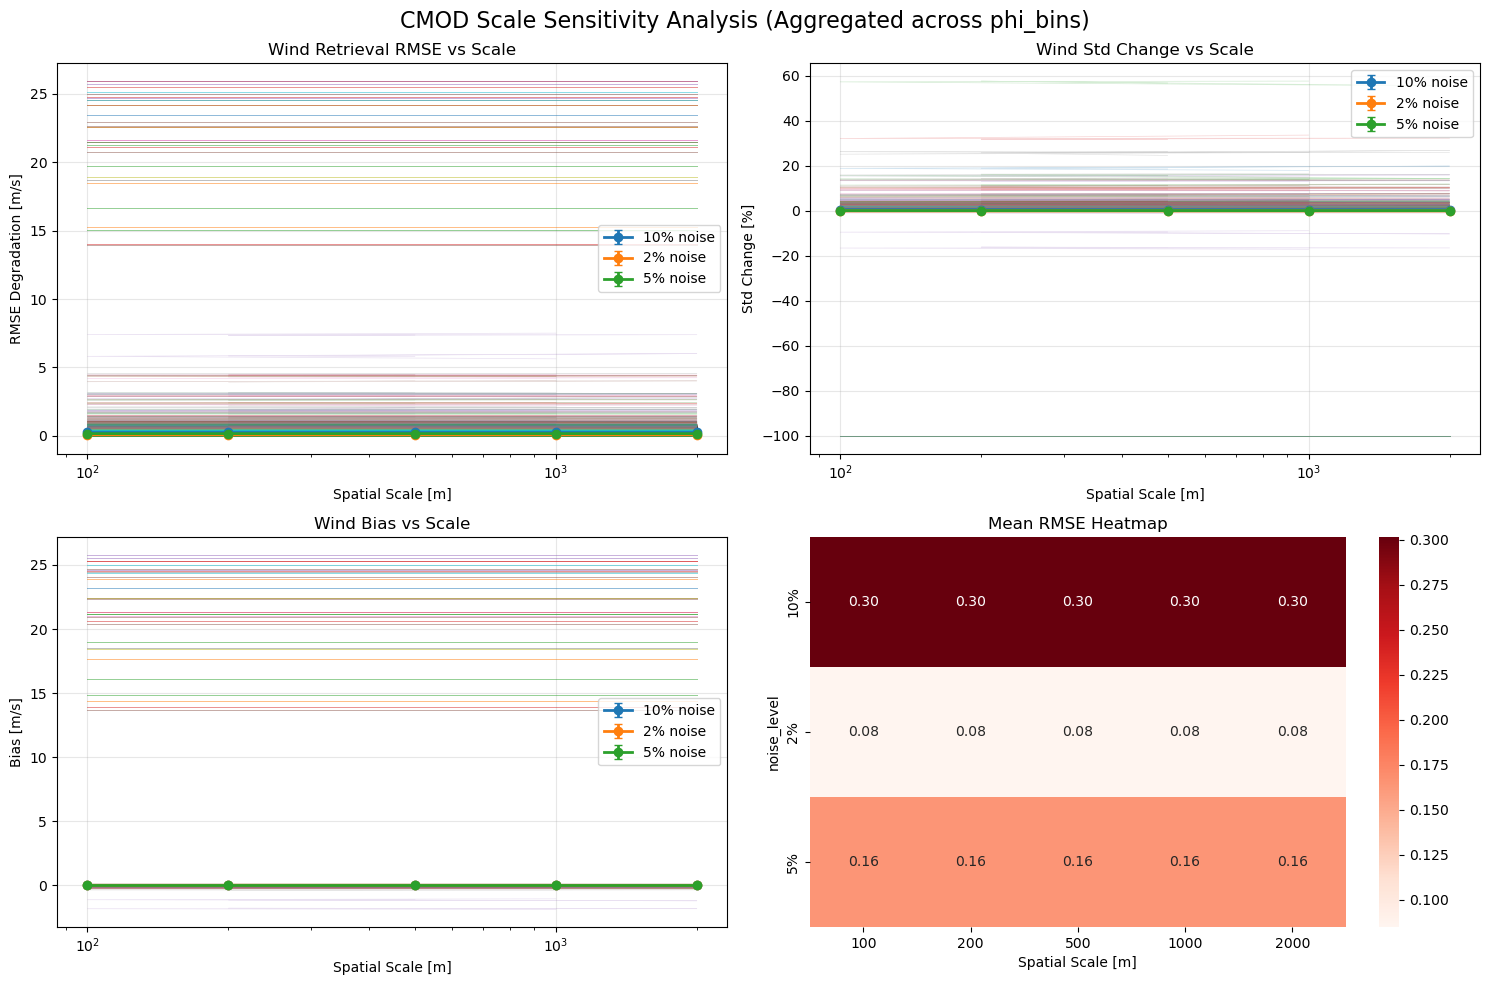

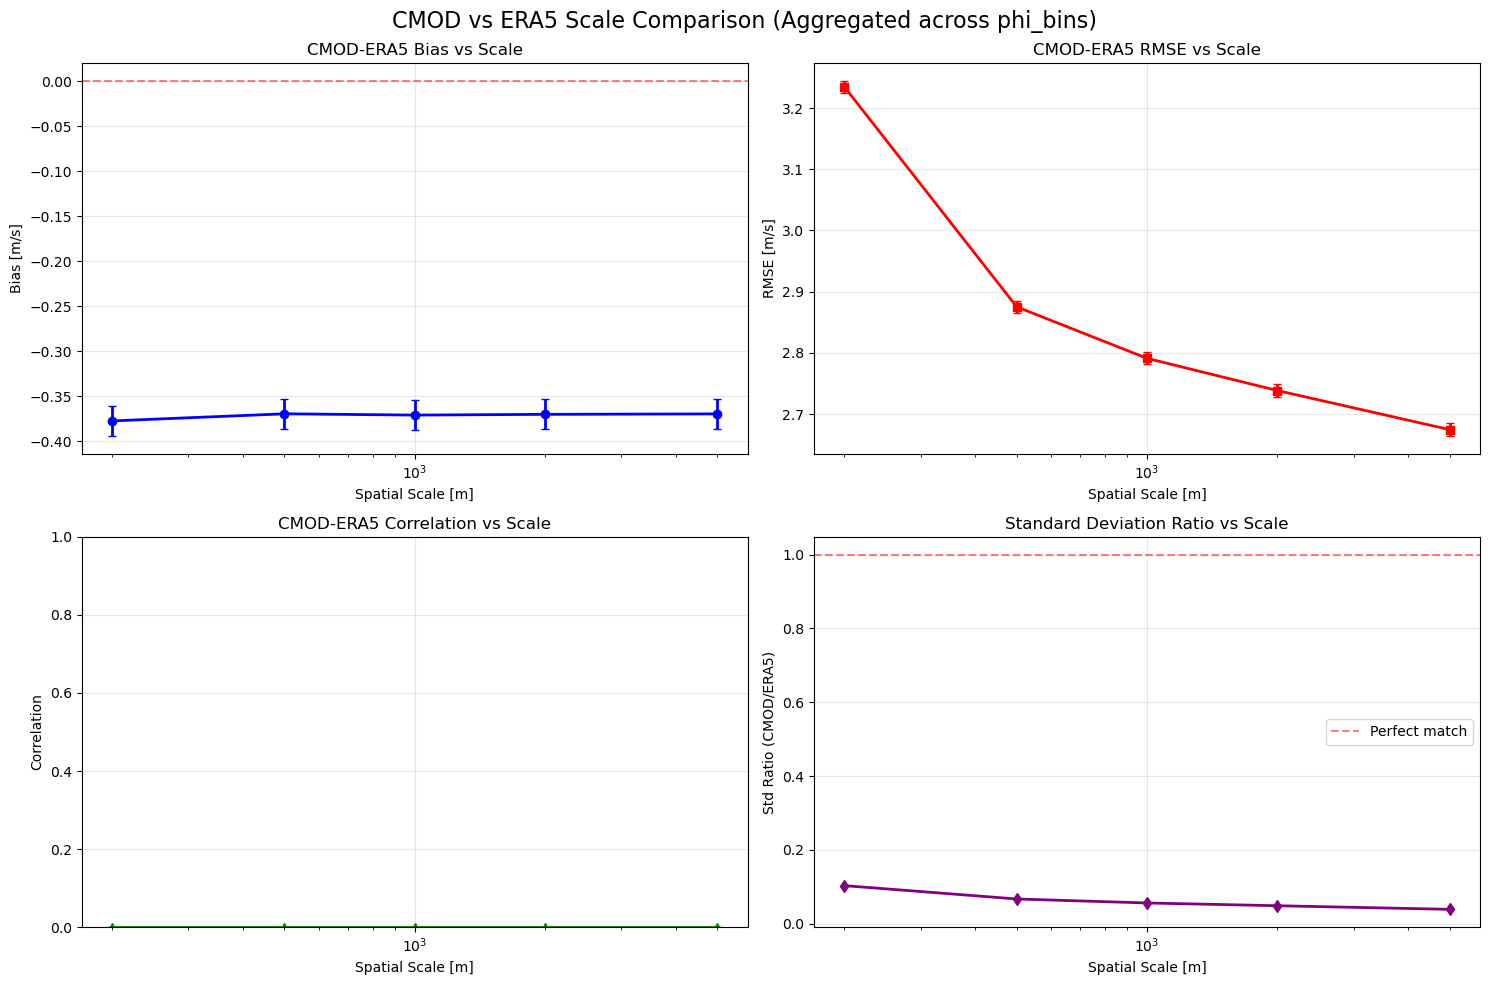

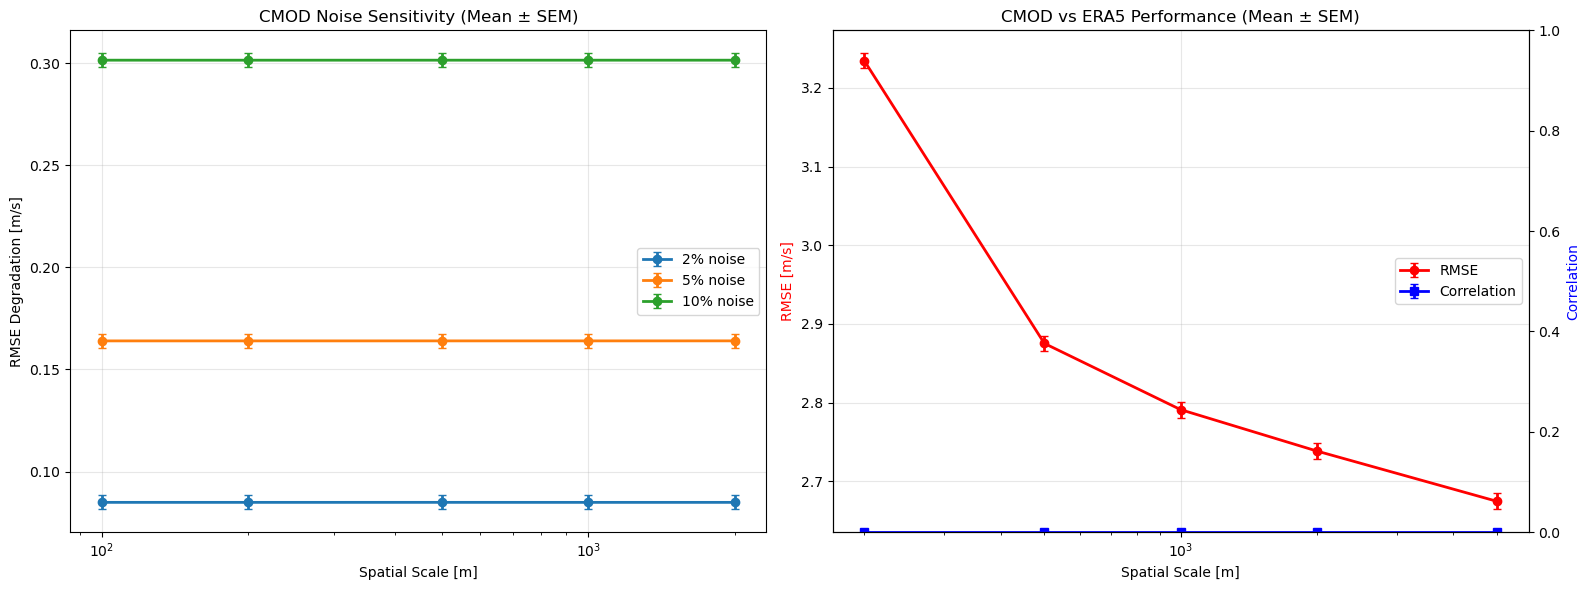

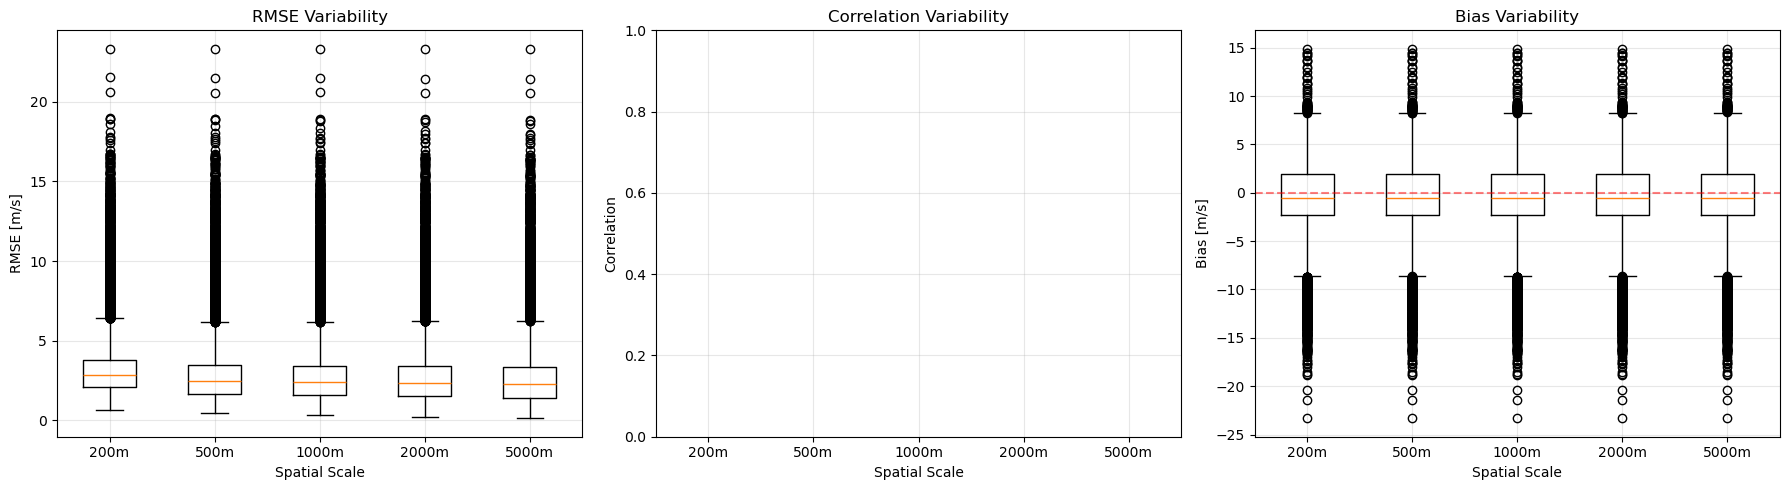

In [ ]:
fig1, data1 = plot_cmod_scale_sensitivity_aggregated(df2, show_individual=True)
fig2, data2 = plot_cmod_era5_comparison_aggregated(df2, show_individual=False) 
fig3 = plot_combined_cmod_analysis_aggregated(df2, show_individual=False)
fig4 = plot_phi_bin_variability(df2)
plt.show()